## Ensemble Hybrid deep learning model for HARon  WISDM Dataset

###   Models

In [1]:
##model_wisdm.py
import numpy as np
import pandas as pd
#import seaborn as sns

In [2]:
#preprocess data 
def preprocess(data):
    #column_names = ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = pd.read_csv(data,on_bad_lines='skip',index_col=False)
    df.columns= ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = df.dropna() # removing null values
    df['z_axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'') # Transforming the z-axis to float
    
    #### Label encoding 
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    df['label'] = label.fit_transform(df['activity'])
    
    ##Balanace this Data :Under sampling
    Walking = df[df['activity']=='Walking'].head(48394).copy()
    Jogging = df[df['activity']=='Jogging'].head(48394).copy()
    Upstairs = df[df['activity']=='Upstairs'].head(48394).copy()
    Downstairs = df[df['activity']=='Downstairs'].head(48394).copy()
    Sitting = df[df['activity']=='Sitting'].head(48394).copy()
    Standing = df[df['activity']=='Standing'].copy()
    
    #df_balanced = pd.DataFrame()
    df_balanced = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
    
    ##Normalize/Standardized data
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    X = df_balanced[['x_axis', 'y_axis', 'z_axis']]
    target = df_balanced['label']
    scaler = StandardScaler()
    dx = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(data = dx, columns = X.columns)
    df_scaled['label'] = target.values
    return df_scaled

In [3]:
dff=preprocess('C:/Datasets/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
#dff.head()#dff.head()

C:\Users\adanent\Anaconda3\envs\Annotation_tool\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
## Segmenting samples (windowing) functions 
import scipy.stats as stats
Fs = 20
segment_size =  500# Fs*4 # window size=n_time steps=frame size
step_size =  25 # Fs*2  # step size 
n_features = 3     

def get_segments(df, segment_size, step_size):
    segments = []
    labels = []
    for i in range(0, len(df) - segment_size - 1, step_size):
        xs = dff['x_axis'].values[i: i + segment_size]
        ys = dff['y_axis'].values[i: i + segment_size]
        zs = dff['z_axis'].values[i: i + segment_size]
        label = stats.mode(dff['label'][i: i + segment_size])[0][0] # [0][0] shows the index of the current sequence
        #We used the dstack() to ensure that each array is stacked in such a way that
        #the features are separated in the third dimension, as we would prefer.
        segments.append(np.dstack([xs, ys, zs]))
        labels.append(label)

    # Bring the segments into a better shape
    segments=np.asarray(segments, dtype= np.float32).reshape(-1, segment_size, n_features)
    labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
                
    return segments, labels

In [5]:
X, y = get_segments(dff, segment_size, step_size)

In [6]:
X.shape, y.shape

((11595, 500, 3), (11595, 6))

### CNN-BiLSTM

In [7]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 10, 50
df_X = X.reshape((X.shape[0], n_steps, n_length, n_features))
n_outputs = y.shape[1] #n_outputs= 6

In [8]:
df_X.shape,y.shape,

((11595, 10, 50, 3), (11595, 6))

We can then define a CNN model that expects to read in sequences with a length of 32 time
steps and three features. The entire CNN model can be wrapped in a TimeDistributed layer
to allow the same CNN model to read in each of the four subsequences in the window. The
extracted features are then flattened and provided to the LSTM model to read, extracting its
own features before a final mapping to an activity is made.

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM,Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split

In [10]:
# split data into training set and test set
X_train_main, X_test, y_train_main, y_test = train_test_split(df_X, y,test_size=0.20, random_state=7)

# split training set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_main,y_train_main,test_size=0.30,random_state=7)

In [11]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((6493, 10, 50, 3), (2319, 10, 50, 3), (6493, 6), (2319, 6))

In [12]:
def create_model(optimizer= 'rmsprop' , init= 'glorot_uniform' ):
    # create model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(100)))  # Bidirectional LSTM
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
### Initialize Mode
cnn_Bilstm_model=create_model()

In [14]:
history = cnn_Bilstm_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=50)

Epoch 1/10
130/130 [==============================] - 76s 310ms/step - loss: 0.4514 - accuracy: 0.8229 - val_loss: 0.0900 - val_accuracy: 0.9583
Epoch 2/10
130/130 [==============================] - 36s 280ms/step - loss: 0.0886 - accuracy: 0.9684 - val_loss: 0.0329 - val_accuracy: 0.9910
Epoch 3/10
130/130 [==============================] - 43s 332ms/step - loss: 0.0439 - accuracy: 0.9858 - val_loss: 0.0308 - val_accuracy: 0.9953
Epoch 4/10
130/130 [==============================] - 57s 439ms/step - loss: 0.0187 - accuracy: 0.9952 - val_loss: 0.0182 - val_accuracy: 0.9950
Epoch 5/10
130/130 [==============================] - 52s 401ms/step - loss: 0.0206 - accuracy: 0.9929 - val_loss: 0.0203 - val_accuracy: 0.9914
Epoch 6/10
130/130 [==============================] - 60s 466ms/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.0054 - val_accuracy: 0.9986
Epoch 7/10
130/130 [==============================] - 64s 496ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.0074 - val_ac

## Save Model

In [15]:
cnn_Bilstm_model.save('cnn_bilstm_500.h5')

###  Evaluate Model

In [16]:
# Make Predictions on test 
y_pred_test = cnn_Bilstm_model.predict(X_test) #class Prediction 

y_pred_test[:5], #y_probs_test[:5]

73/73 [==============================] - 27s 132ms/step


(array([[1.1484433e-05, 1.8871091e-08, 9.9997163e-01, 7.9848013e-07,
         1.5760119e-05, 3.6362752e-07],
        [3.9433107e-06, 4.3510327e-06, 2.1336976e-04, 9.9976653e-01,
         7.5309199e-06, 4.3193304e-06],
        [3.9761861e-05, 7.1679090e-10, 1.7230977e-06, 4.1391456e-08,
         9.9995732e-01, 1.1576122e-06],
        [9.9956840e-01, 4.1656940e-06, 1.9416102e-05, 3.1202299e-07,
         4.0681136e-04, 8.5888314e-07],
        [6.5280078e-06, 6.6167477e-06, 2.5732873e-04, 9.9970680e-01,
         1.5251143e-05, 7.3667466e-06]], dtype=float32),)

In [17]:
y_pred_test=np.argmax(y_pred_test,axis=1) 
y_true_test=np.argmax(y_test,axis=1) 

y_true_test.shape, y_pred_test.shape

((2319,), (2319,))

In [18]:
import seaborn as sns
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true_test,y_pred_test)
print(cm)
print(acc(y_true_test,y_pred_test))
print(classification_report(y_true_test,y_pred_test))

[[392   0   0   0   0   0]
 [  0 403   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 374   0   0]
 [  0   0   0   0 414   0]
 [  0   2   0   0   0 378]]
0.9991375592927986
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       392
           1       1.00      1.00      1.00       403
           2       1.00      1.00      1.00       356
           3       1.00      1.00      1.00       374
           4       1.00      1.00      1.00       414
           5       1.00      0.99      1.00       380

    accuracy                           1.00      2319
   macro avg       1.00      1.00      1.00      2319
weighted avg       1.00      1.00      1.00      2319



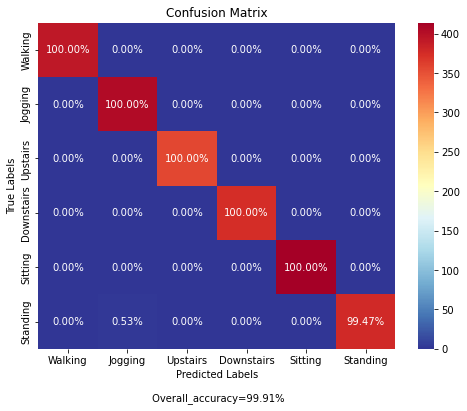

In [19]:
cf=np.empty((6,6))
for i in range(6):
    cf[i]=(cm[i]/np.sum(cm[i]))
    
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(6,6)

fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(acc(y_true_test,y_pred_test)))
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
ax.yaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
plt.savefig('ConfusionMatrix_Ensem-HAR_WISDM',dpi=1200, bbox_inches='tight')

In [20]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')

(0.9991769547325102, 0.9991228070175439, 0.9991477050079677, None)